a. Using the provided function V,

(1) plot the strength of the potential between two particles x0 = (x, 0, 0) and x1 = (0, 0, 0). Do this by writing a function that takes in a single scalar argument x, and calculates the potential using V, with x ranging between 3 and 11. 

In [3]:
def same(a,b):
    return np.isclose(a,b).all()

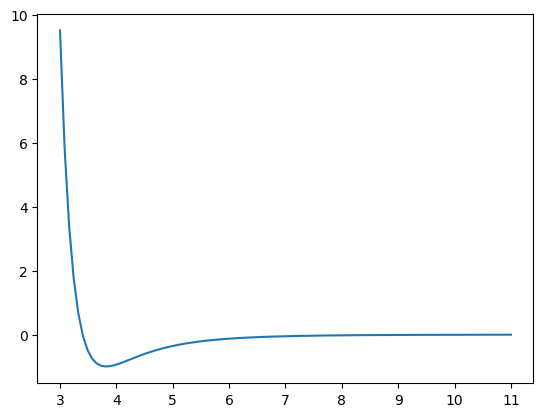

In [280]:
import numpy as np
from project_files.LJhelperfunctions import V


def pot_1(x : float) -> float:
    points = np.stack(([0,0,0],[x,0,0]))
    return V(points)


(2) Plot the strength of the potential between four particles: x0 and x1 as before, x2 = (14, 0, 0) and x3 = (7, 3.2, 0), again with x ranging from 3 to 11. Do this by again writing a function that takes a single scalar argument x and returns the potential strength. 

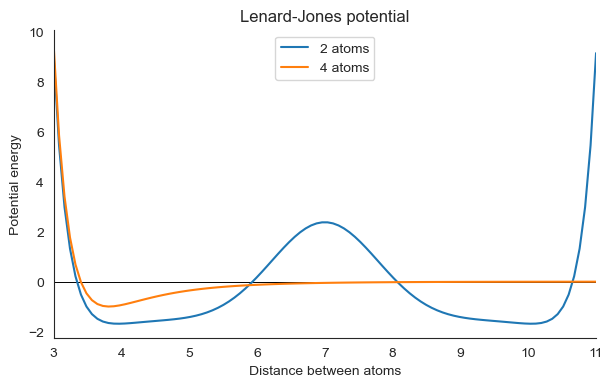

In [309]:
import seaborn as sns
sns.set_style("white")

def pot_2(x : float) -> float:
    points = np.stack(([0,0,0],[x,0,0],[14,0,0],[7,3.2,0]))
    return V(points)



_range = np.linspace(3, 11, 100)
potentials1 = np.array([pot_2(x) for x in _range])



_range = np.linspace(3, 11, 100)
potentials2 = np.array([pot_1(x) for x in _range])

import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.hlines(0,-3,12, colors="black", linewidth=0.7)
plt.plot(_range, potentials1, label="2 atoms")
plt.plot(_range, potentials2, label="4 atoms")
plt.legend(loc = "upper center")
plt.xlabel("Distance between atoms")
plt.ylabel("Potential energy")
plt.xlim(3,11)
plt.title("Lenard-Jones potential")
sns.despine()
plt.show()

b. 

Write a bisection root finding function x, n calls = bisection root(f,a,b,tolerance=1e−13) that finds x such that f(x) = 0 given a bracket x ∈ [a; b], and counts the number of calls to the function f. (A reasonable length is 8-12 lines of code). 

In this assignment, let the convergence test be on how close we get f(x) to zero. Test it to find the zero of the the LJ-potential between two argon atoms as a function of interatomic distance, and verify that you get x = σ. How many calls to the energy function were needed to get from the start bracket [a, b] = [2, 6] to |f(x)| < 10−13? 

In [307]:
def bisection_root(f, a : float, b : float, tolerance : float=1e-13 ) -> tuple[float, int]:
    def f_count(x):
        f_count.count += 1
        return f(x)
    f_count.count = 0

    a_is_previous_m = False
    while ((b - a) > tolerance):
        m = a + (b - a)/2
        fa = f_count(a) if not a_is_previous_m else fm
        fm = f_count(m)
        if np.sign(fa) == np.sign(fm):
            a = m
            a_is_previous_m = True
        else:
            b = m
            a_is_previous_m = False

    return m, f_count.count

In [315]:
from project_files.LJhelperfunctions import SIGMA

ans = bisection_root(pot_1, 2, 6)


print("Answer:", ans[0])
print("Number of calls:", ans[1])
print("Same as sigma?",same(ans[0], SIGMA))

Answer: 3.4010000000000105
Number of calls: 65
Same as sigma? True


c. 

The derivative of the pair-potential $v_{L J}(r)=4 \epsilon\left((\sigma / r)^{12}-(\sigma / r)^6\right)$ is
$$
\frac{d}{d r} v_{L J}(r)=4 \epsilon\left(\frac{6 \sigma^6}{r^7}-\frac{12 \sigma^{12}}{r^{13}}\right)
$$

Write a Newton-Rhapson solver x, n calls = newton root(f,df,x0,tolerance,max iterations), (a reasonable length is 4-8 lines of code), and test it in the same way as above. For simplicity, assume that a call to the derivative df has the same cost as a call to f. How many calls were needed to get from x0 = 2 to |f(x∗)| < 10−12, i.e., 12 decimal digits for x∗ after the comma? 

In [329]:
def newton_root(f,df,x0,tolerance, max_iterations) -> tuple[float, int]:
    for i in range(max_iterations):
        f_val = f(x0)
        x0 -= f_val/df(x0)
        if abs(f_val) < tolerance:
            break

    return x0, i*2 # 2 calls to f(x) (or f'(x)) per iteration

from project_files.LJhelperfunctions import SIGMA, EPSILON

def dpot_1(r : float) -> float:
    return 4*EPSILON*(6*SIGMA**6/r**7 - 12*SIGMA**12/r**13)


ans = newton_root(pot_1, dpot_1, 2, 1e-12, 1000)
print(ans)
print(same(ans[0], SIGMA))

(3.4009999999999994, 24)
True


d. 

Make a combination of Newton-Rhapson and bisection that is guaranteed to converge (when run on an interval bracketing a zero), but takes advantage of the quadratic convergence of Newton-Rhapson iteration, and test it on the same example. How many calls to the LJ-energy function was needed to get from x0 = 2, [a, b] = [2, 6] to obtain |f(x∗)| < 10−13? 

$\textit{Note: If you have trouble completing this step, simply skip it and move on to the remaining questions,}$

$\textit{which only requires your bisection root solver to work. You can always return to solve it once you have completed tasks (e) and (f). }$

In [326]:
def root(f,df,x0, tolerance, max_iterations) -> tuple[float, int]:

    last = abs(f(x0))
    for i in range(max_iterations):
        f_val = f(x0)

        x0 -= f_val/df(x0)

        # when converging use newton
        if abs(f_val) < tolerance:
            break
        
        # when diverging use bisection
        if f_val > last:
            print("Diverging")
            ans = bisection_root(f, -f_val, f_val, tolerance)
            return ans[0], i*2 + ans[1]
        
        last = f_val

    return x0, i*2 # 2 calls to f(x) (or f'(x)) per Newton iteration

In [330]:
root(pot_1, dpot_1, 2, 1e-13, 1000)

(3.4009999999999994, 24)

e.

 Look at the gradient of the 2-particle system in question (a) with x1 = (0, 0, 0) and x0 = (x, 0, 0), x ∈ [3; 10]. Why are exactly two components nonzero? Why are they equal and opposite? Plot the nonzero component for the derivative of the x-coordinate of x0 (0, 0coordinate of gradient) together with the potential, and notice the relationship between the zero of the derivative and the minimum of the potential. Next look at the gradient for the 4-particle system from (a) at one of the minima of your plot. Why is the gradient not zero? 

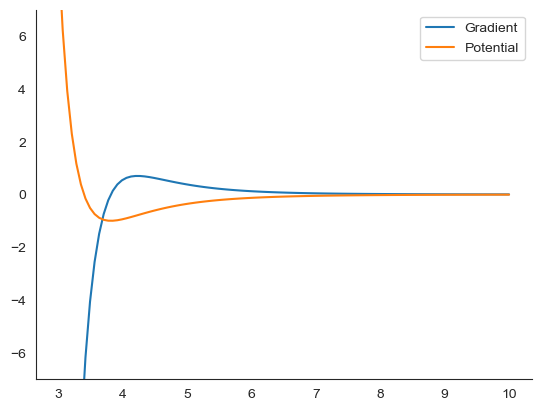

In [339]:
from project_files.LJhelperfunctions import gradV

# make vectorized

def gradV_2_particle(x):
    points = np.stack(([x,0,0],[0,0,0]))
    return gradV(points)


rs = np.linspace(3, 10, 100)

gradient = np.array([gradV_2_particle(r)[0,0] for r in rs]) # only in x direction and only for the first particle

potential = np.array([pot_1(r) for r in rs]) 

plt.plot(rs, gradient, label="Gradient")

plt.plot(rs,potential, label="Potential")

plt.legend()
plt.ylim(-7,7)
sns.despine()
plt.show()

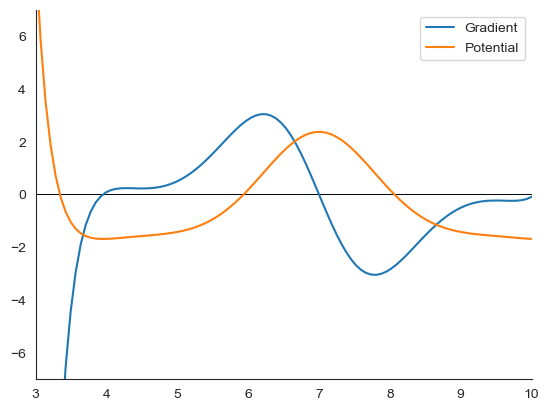

In [342]:
def gradV_4_particle(x):
    points = np.stack(([x,0,0],[0,0,0],[14,0,0],[7,3.2,0]))
    return gradV(points)  


rs = np.linspace(3, 10, 100)

gradient = np.array([gradV_4_particle(r)[0,0] for r in rs]) # only in x direction and only for the first particle

potential = np.array([pot_2(r) for r in rs]) 

plt.hlines(0,0,15, colors = "black", linewidth = 0.7)
plt.plot(rs, gradient, label="Gradient")

plt.plot(rs,potential, label="Potential")


plt.legend()

plt.ylim(-7,7)
plt.xlim(3,10)
sns.despine()
plt.show()

f. Write a function alpha, ncalls = linesearch(F,X0, d, alpha max, tolerance, max iterations) that takes a function F : RN×3 → RN×3, a start position X0 ∈ RN×3 and finds the zero along the line-segment X0 + αd of d · F(X0 + αd).2 Use your bisection solver at this point, as using Newton-Rhapson requires second derivatives when F is the gradient. 

Test you function using:

DEN HER


In [272]:
def make_line_func(X0, d, f):
    def f_line(alpha):
        _f = f(X0 + alpha * d)
        return _f
    return f_line

def make_line_deriv(X0, d, f):
    lf = make_line_func(X0, d, f)
    def f_line_deriv(alpha):
        return d.dot(lf(alpha))
    return f_line_deriv

def linesearch(F, X0, d, alpha_max=1, tolerance=1e-13, max_iterations=10000) -> tuple[float, int]:
    f_line = make_line_deriv(X0, d, F)
    
    alpha, ncalls = bisection_root(f_line, 0, alpha_max, tolerance=tolerance)
    return alpha, ncalls


X0 = np.array([[4,0,0],[0,0,0],[14,0,0],[7,3.2,0]])
from project_files.LJhelperfunctions import flat_gradV
d = -flat_gradV(X0)
alpha_max = 1


alpha, ncalls = linesearch(flat_gradV, X0.flatten(), d, alpha_max, tolerance=1e-12)

print(alpha, ncalls)

0.451707051842277 80


g.
 
Write a function x opt, n calls = golden section min(f,a,b,tolerance=1e−3) that finds the minimum of a 1D-function on a unimodal interval x ∈ [a; b], and use it to obtain the same α as you did in (f), but without using the gradient. Next, use your golden section function to obtain the optimal (minimal-energy) distance r0 between two Ar atoms. 

In [276]:
def golden_section_min(f,a,b,tolerance=1e-3) -> tuple[float, int]:
    phi = (np.sqrt(5) - 1)/2 
    x1 = a + (1 - phi)*(b - a) 
    f1 = f(x1)
    x2 = a + phi*(b - a) 
    f2 = f(x2)

    count = 2

    while ((b - a) > tolerance): 
        if (f1 > f2):
            a = x1 
            x1 = x2 
            f1 = f2 
            x2 = a + phi*(b - a) 
            f2 = f(x2)
        else:
            b = x2 
            x2 = x1 
            f2 = f1 
            x1 = a + (1 - phi)*(b - a) 
            f1 = f(x1) 

        count += 1

    return (a + b)/2, count


from project_files.LJhelperfunctions import flat_V

X0 = np.array([[4,0,0],[0,0,0],[14,0,0],[7,3.2,0]])
d = -gradV(X0)



f_line = make_line_func(X0.flatten(), -gradV(X0).flatten(), flat_V)
# f = line_function( F=flat_V, x0=x0.flatten(), d=-gradV_func(x0).flatten() )

r0 = golden_section_min(pot_1, 2, 6)[0]
print(r0)
r1 = golden_section_min(f_line, 0, 1)

print(r1)

3.8172876299217666
(0.4516693913190848, 17)


h. 

Write a function X opt, N calls, converged = BFGS(f,gradf, X,tolerance=1e−6, max iterations=10000) which implements BFGS either with the direct step (approximating the Hessian) or inverse steps (approximating the Hessian inverse), as covered in the lectures. converged is a boolean which is True iff you converged to the requested tolerance within max iterations steps. 

Test it to find the minimum of the two-particle system, but using the N-particle potential for the two points defined by the array Xstart2 in ArStarts. Confirm that this yields the same r0 as above. 

In [278]:
from numpy.typing import ArrayLike
from project_files.LJhelperfunctions import flatten_function, flatten_gradient

def BFGS(f, gradf, X, tolerance = 1e-6, max_iterations = 10000, linesearch = False) -> tuple[ArrayLike, int, bool]:
    x0 = flatten_gradient(X)
    x0 = X
    B0 = np.eye(len(X))
    gradfx0 = gradf(x0)
    for k in range(1,max_iterations):
        sk = np.linalg.solve(B0, -gradfx0)
        x1 = x0 + sk
        gradfx1 = gradf(x1)
        yk = gradfx1 - gradfx0

        if np.linalg.norm(yk) < tolerance:
            return x1, k, True
        B0 += np.outer(yk, yk)/np.dot(yk, sk) \
                - np.outer(np.dot(B0, sk), np.dot(B0, sk))/np.dot(sk, np.dot(B0, sk))
        
        x0 = x1
        gradfx0 = gradfx1

    
    return x0, 1 + k, False

from project_files.LJhelperfunctions import V, gradV


from project_files.LJhelperfunctions import flat_V, flat_gradV


ArStarts = np.load("project_files\ArStart.npz")

print(ArStarts["Xstart2"])
# r1 = BFGS(pot_1, dpot_1, ArStarts["Xstart2"])[0][0]
print((r1 := BFGS(flat_V, flat_gradV, ArStarts["Xstart2"])))


# print(flat_V(r1[0]))

# print(same(flat_V(r1[0]), pot_1(r0)))
# # print(r0)
# print(r1)
# print(same(r0,r1))

[3.68030534 3.93004011 1.48370367 3.00184683 0.30888719 0.55260454]
(array([3.68186699, 3.93837516, 1.48584684, 3.00028518, 0.30055214,
       0.55046137]), 7, True)


i. 

Apply your BFGS-minimizer to the starting geometries from ArStarts, starting with N = 2 and stopping when you reach an N you can’t get to converge. Inspect the distance matrix. How many distances are within 1% of the two-particle optimum r0? You can count them automatically by writing sum(abs(D−r0)/r0 <= 0.02)//2 if D is the distance matrix.

Inspect the results in 3D. The true minimum corresponds to the zero-temperature configuration of the system if left to slowly cool. A good optimum should look something like a single lattice, where as many atoms as possible are trapped in the potential well of one or more neighbours. Show the 3D picture for N = 3 and your highest converged N. 

In [233]:
from scipy.spatial.distance import pdist, squareform

starting_geometries = list(ArStarts.values())


points = []
for start in starting_geometries:
    start = start.flatten()
    try:
        ans = BFGS(flat_V, flat_gradV, start, tolerance=1e-12)
        D = squareform(pdist(ans[0].reshape(-1,3)))
        s = np.sum(abs(D-r0)/r0 <= 0.02)//2

        print("n_close:",s)
        points.append(ans[0])
        print("converged",ans[2])
    except:
        print("False")
        pass

n_close: 1
converged True
n_close: 0
converged True
n_close: 0
converged True
n_close: 0
converged True
n_close: 0
converged True
n_close: 0
converged True
n_close: 0
converged True
n_close: 0
converged True
n_close: 0
converged True
n_close: 0
converged True


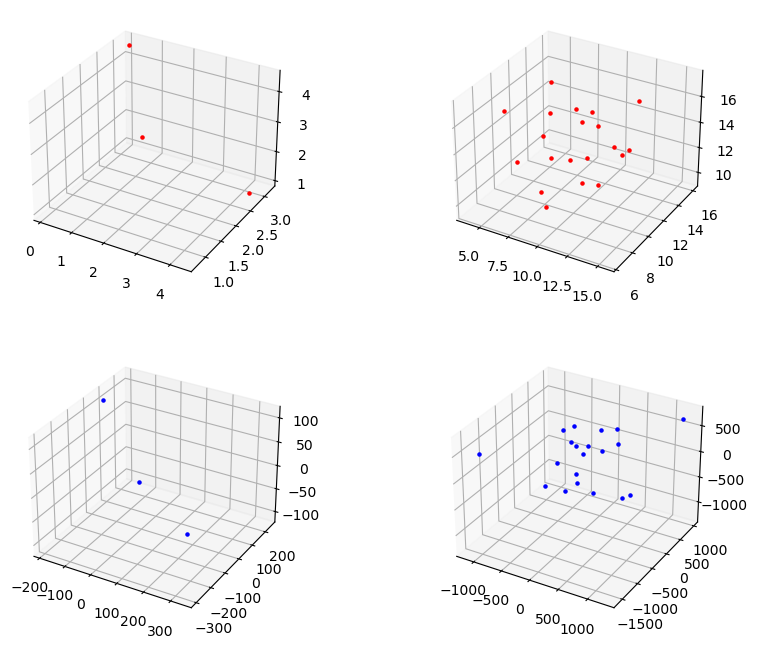

In [277]:
# plot 3d

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,8))

names = ArStarts.keys()

for i, startpoint in enumerate([starting_geometries[1], starting_geometries[-1]], start=1):
    ax = fig.add_subplot(2,2,i, projection='3d')
    for sp in startpoint.reshape((-1,3)):
        ax.scatter(sp[0], sp[1], sp[2], marker='.', color='red')

for i, point in enumerate([points[1], points[-1]], start=1):
    ax = fig.add_subplot(2,2,i+2, projection='3d')
    for p in point.reshape((-1,3)):
        ax.scatter(p[0], p[1], p[2], marker='.', color='blue')

plt.show()




j. 

Add a line-search step to your BFGS-function, such that your change in x becomes α∆x instead of directly using the ∆x obtained from Bk+1∆xk = −∇f(Xk) (or ∆xk = − B˜k+1∇f(Xk) for inverse BFGS iteration). Use both to find the minima for the N-particle starting positions from ArStarts for increasing N. Does it affect the number of steps needed to converge? Can you get higher N to converge than before? Does it change the quality of the solution (the number of van der Waals “bonds” between atoms). What about the total number of function calls needed to converge? 

Finally, a bonus task. You can leave this out and still obtain a full score, or you can solve it and get extra points towards a full score: to make up for not completing previous tasks, or for your own satisfaction. 

k. 

Implement one of the meta-heuristics of your own choice, and use it to minimize the energy for N = 5, N = 9 and N = 20. Are you now able to obtain a good solution for higher N? Show the 3D picture and the number of van der Waals “bonds”. Compare the convergence to that of the dampened BFGS from (j): Trace the energies and accumulated number of function calls at each iteration step, and plot the energy 1) per iteration step, and 2) as a function of accumulated number of function calls. 